In [11]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib
from matplotlib import rcParams
import matplotlib.pyplot as plt
import smplotlib
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 14
    
import numpy as np
import pandas as pd
from astropy.table import Table
from astropy.io import fits
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from nuwa.wlkernel import make_graph, calculate_grakel_graph, GaussianProcess
import multiprocessing
import os
from grakel import Graph
from grakel.kernels import WeisfeilerLehman, VertexHistogram
from scipy.sparse import lil_matrix
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import cKDTree
from sklearn.neighbors import KDTree
np.set_printoptions(suppress=True)


In [19]:

data_dir = "/nfsdata/users/jdli_ny/wlkernel/mock/"
data = np.load(data_dir+'binary_train_flatZ_abg.npz')


# Split X and Y into training and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(
    data['X'], data['Y'], test_size=0.1, random_state=42
)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)


for d in [X_train, X_test, Y_train, Y_test]:

    print(len(d[np.isnan(d)]))
    # d = d[~np.isnan(d).any(axis=1)]
    print(d.shape)

(450, 5000, 2) (50, 5000, 2) (450, 3) (50, 3)
0
(450, 5000, 2)
0
(50, 5000, 2)
0
(450, 3)
0
(50, 3)


# train

In [13]:
num_cpu = 24
radius  = 0.1
subsample_factor = 1
n_iter = 3

# Make the graph objects for all realisations in parallel
with multiprocessing.Pool(processes=num_cpu) as pool:
    graph_list, degree_list = zip(*pool.map(make_graph, tqdm([(i, X_train[i], radius, subsample_factor) for i in range(X_train.shape[0])])))

    
# Initialize the grakel graph kernel
wl_kernel = WeisfeilerLehman(n_iter=n_iter, base_graph_kernel=VertexHistogram)
args_list = [(i, graph_list[i], degree_list[i]) for i in range(len(graph_list))]


# Calculate grakel graphs in parallel
with multiprocessing.Pool(processes=num_cpu) as pool:
    grakel_list = list(tqdm(pool.imap(calculate_grakel_graph, args_list), total=len(graph_list)))



100%|██████████| 450/450 [06:13<00:00,  1.21it/s]


[[1.         0.23387615 0.71505935 ... 0.50171396 0.29690517 0.56426563]
 [0.23387615 0.22694333 0.23737513 ... 0.23692739 0.21994656 0.23792354]
 [0.71505935 0.23737513 0.6385011  ... 0.47892794 0.30010803 0.53230575]
 ...
 [0.50171396 0.23692739 0.47892794 ... 0.48525667 0.29611274 0.47433213]
 [0.29690517 0.21994656 0.30010803 ... 0.29611274 0.28693059 0.30093243]
 [0.56426563 0.23792354 0.53230575 ... 0.47433213 0.30093243 0.53896613]]
0.0
82195.9006798246


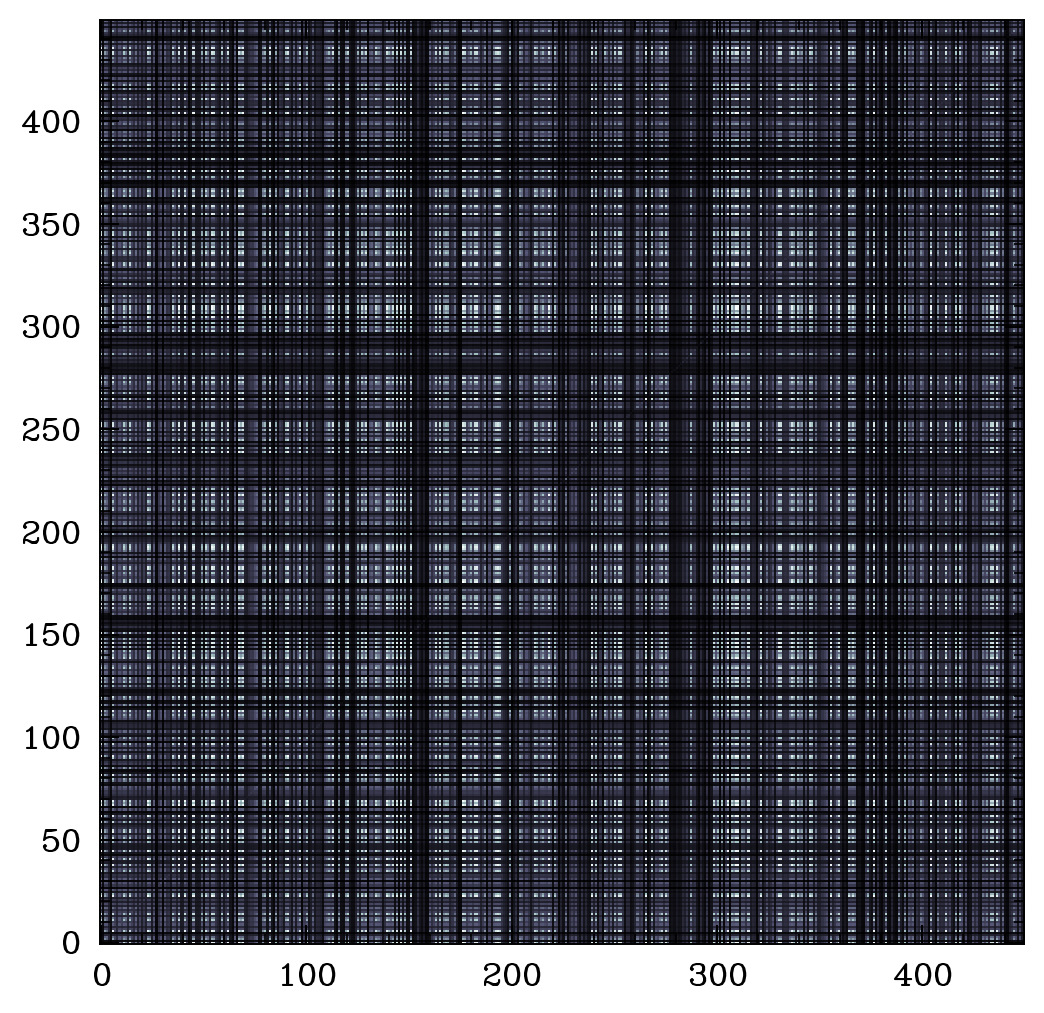

In [14]:
# Normalize kernel values
kernel_values = wl_kernel.fit_transform(grakel_list)
kernel_values = kernel_values / np.max(kernel_values)

print(kernel_values)
print(np.linalg.det(kernel_values))
print(np.linalg.cond(kernel_values))

plt.imshow(kernel_values, cmap='bone')

# validation

In [15]:
# Make the graph objects for all realisations in parallel
with multiprocessing.Pool(processes=num_cpu) as pool:
    graph_list, degree_list = zip(*pool.map(make_graph, tqdm([(i, X_test[i], radius, subsample_factor) for i in range(X_test.shape[0])])))

    
# wl_kernel = WeisfeilerLehman(n_iter=n_iter, base_graph_kernel=VertexHistogram)
args_list = [(i, graph_list[i], degree_list[i]) for i in range(len(graph_list))]


# Calculate grakel graphs in parallel
with multiprocessing.Pool(processes=num_cpu) as pool:
    grakel_list_test = list(tqdm(pool.imap(calculate_grakel_graph, args_list), total=len(graph_list)))


100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


In [16]:
# Normalize kernel values
K_star = wl_kernel.transform(grakel_list_test)
K_star = K_star / np.max(K_star)

# np.save(data_dir+"test_kernel_values_flatZ.npy", K_star)

In [20]:
class GaussianProcess:
    
    def __init__(self, K, K_star, K_star_star=None):
        # self.kernel = kernel
        self.K = K
        self.K_star = K_star
        # self.K_star_star = K_star_star
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def predict(self):
        # K = self.kernel(self.X_train, self.X_train)
        self.K_inv = np.linalg.inv(self.K)
        
        # K_star = self.kernel(self.X_train, X_test)
        mu = self.K_star @ self.K_inv @ self.y_train
        # cov = self.K_star_star - self.K_star @ self.K_inv @ self.K_star
        return mu
    
gp = GaussianProcess(kernel_values, K_star)
gp.fit(X_train, Y_train)

y_pred = gp.predict()
y_pred

array([[ 3.06032502,  0.42070694,  1.81378632],
       [ 3.54464316,  0.45350989,  1.59463238],
       [ 1.32531219,  0.47272593,  1.87328829],
       [ 1.86492156,  0.49123116,  2.07076699],
       [ 3.81770973,  0.49267841,  2.30865501],
       [ 2.12548785,  0.5999418 ,  2.77265424],
       [ 1.20876176,  0.48729471,  1.25057792],
       [ 1.81287289,  0.52178446,  1.75462543],
       [ 1.33134083,  0.51279307,  2.33278907],
       [ 3.4408257 ,  0.60372433,  1.6533778 ],
       [ 3.24888004,  0.54371775,  1.47281998],
       [ 2.11747142,  0.48591707,  2.24569826],
       [ 2.32268191,  0.67274291,  1.58158185],
       [ 2.04280035,  0.40631598,  1.13670107],
       [ 1.20241973,  0.48048263,  1.53698523],
       [ 3.37371718,  0.41941885,  2.01045475],
       [ 2.16218242,  0.5091163 ,  2.47074226],
       [ 2.93472857,  0.47564125,  1.85563102],
       [ 2.36834819,  0.61270596,  1.85400531],
       [ 3.81425954,  0.37958026,  2.77348643],
       [ 2.47610478,  0.54675872,  1.885

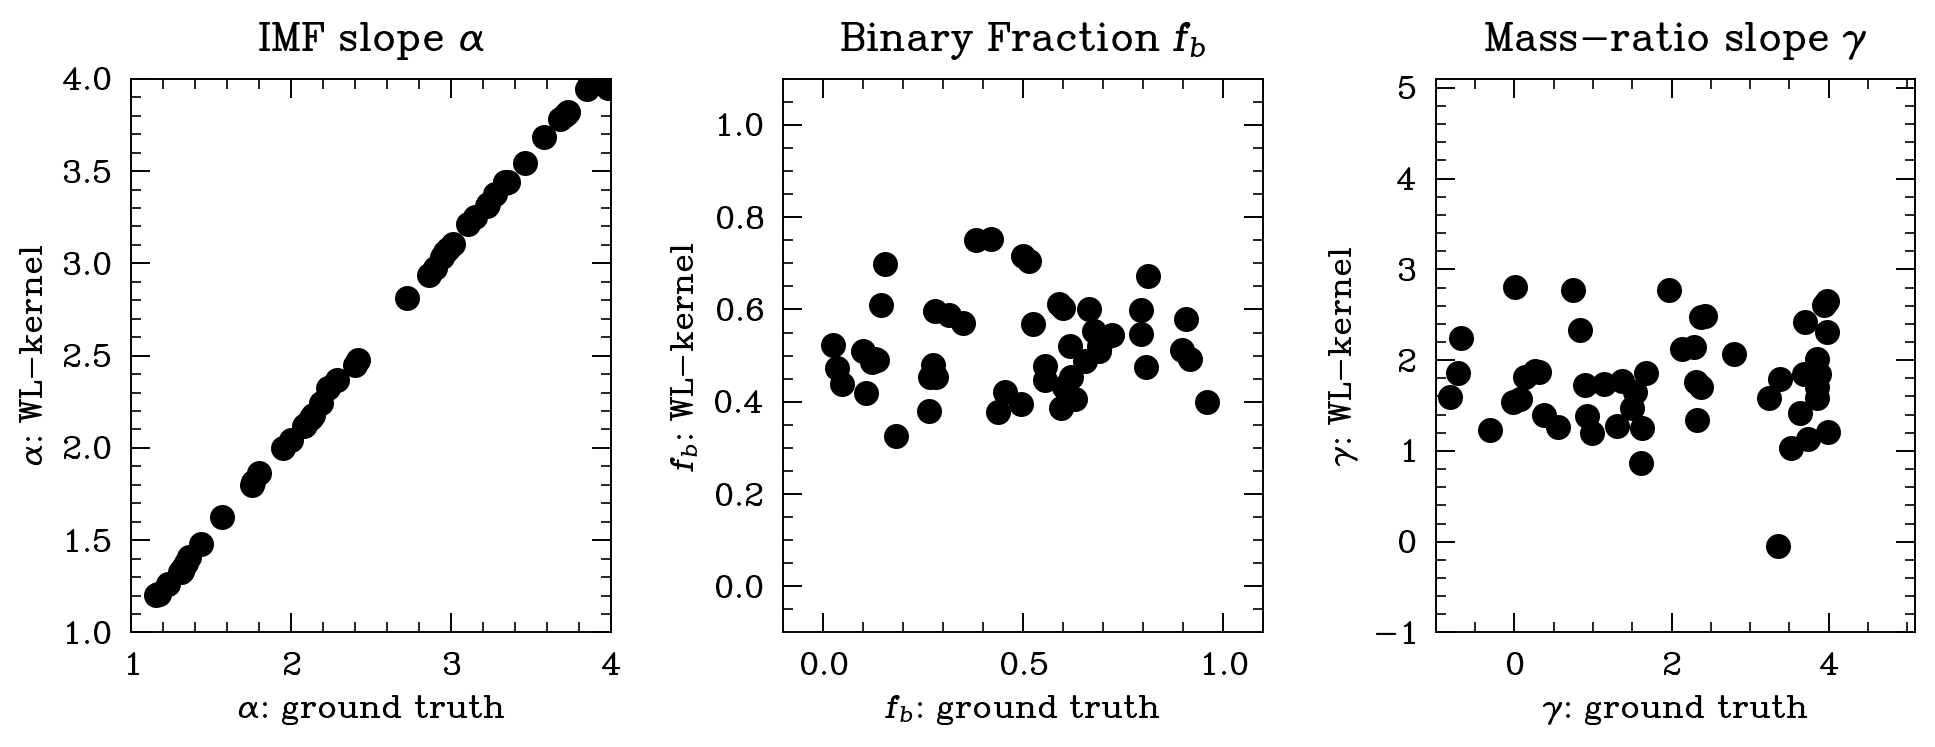

In [22]:
# Create one-to-one comparison plot
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 4))

ax1.scatter(Y_test[:,0], y_pred[:,0], )
ax2.scatter(Y_test[:,1], y_pred[:,1], )
ax3.scatter(Y_test[:,2], y_pred[:,2], )

ax1.set_xlim(1., 4.);
ax1.set_ylim(1., 4.);
ax1.set_xlabel(r"$\alpha$: ground truth");
ax1.set_ylabel(r"$\alpha$: WL-kernel");


ax2.set_xlim(-0.1, 1.1);
ax2.set_ylim(-0.1, 1.1);
ax2.set_xlabel(r"$f_b$: ground truth");
ax2.set_ylabel(r"$f_b$: WL-kernel");


ax3.set_xlim(-1, 5.1);
ax3.set_ylim(-1, 5.1);
ax3.set_xlabel(r"$\gamma$: ground truth");
ax3.set_ylabel(r"$\gamma$: WL-kernel");

ax1.set_title(r'IMF slope $\alpha$')
ax2.set_title(r'Binary Fraction $f_b$')
ax3.set_title(r'Mass-ratio slope $\gamma$')

plt.tight_layout()

In [64]:
import pickle

model_dir = "/nfsdata/users/jdli_ny/wlkernel/model/"

with open(model_dir+'wl_kernel.pkl', 'wb') as f:
    pickle.dump(wl_kernel, f)


np.save(model_dir+"kernel_values_flatZ.npy", kernel_values)